# TreeCorr Tutorial

Using jackknife regions from healpixels we build an estimator of the convariance matrix of the angula correlation function. 

In [34]:
import numpy as np
import h5py
import healpy as hp
import matplotlib.pyplot as plt
from astropy.table import Table
import seaborn as sns
sns.set_context('talk')

## Read The Data

In [35]:
path = '/project/projectdirs/des/www/y3_cats/'
rm_fname = path+'y3_gold_2.2.1_wide_sofcol_run_redmapper_v0.5.1_redmagic_12_3_19.h5'

In [36]:
print('Taking a look at data structure')
rm = h5py.File(rm_fname,'r+')
print('all:',list(rm.keys()))
print()
cat = rm['catalog/redmapper/lgt5']
ran = rm['randoms/redmapper/lgt5']
print('redMaPPer columns:',list(cat.keys()))
print()
print('random columns: ',list(ran.keys()))
rm.close()

Taking a look at data structure
all: ['catalog', 'index', 'masks', 'randoms', 'regions']

redMaPPer columns: ['bcg_ilum', 'bcg_spec_z', 'c_lambda', 'c_lambda_err', 'chisq', 'dec', 'dec_cent', 'dec_orig', 'dlambda_dz', 'dlambda_dz2', 'dlambdavar_dz', 'dlambdavar_dz2', 'ebv_mean', 'geomaskfrac', 'id_cent', 'ilum', 'lambda_chisq', 'lambda_chisq_c', 'lambda_chisq_ce', 'lambda_chisq_cent', 'lambda_chisq_e', 'lambda_zred', 'lambda_zred_e', 'lim_exptime', 'lim_limmag', 'lim_limmag_dered', 'lim_limmag_hard', 'lnbcglike', 'lnlamlike', 'lnlike', 'mag_lambda_err', 'maskfrac', 'maskgal_index', 'mem_match_id', 'members', 'model_mag', 'model_magerr', 'ncent', 'ncent_good', 'ncross', 'p_bcg', 'p_c', 'p_cen', 'p_fg', 'p_sat', 'pz', 'pzbins', 'q_cen', 'q_miss', 'r_lambda', 'ra', 'ra_cent', 'ra_orig', 'refmag', 'refmag_err', 'rmask', 'scaleval', 'w', 'z', 'z_init', 'z_lambda', 'z_lambda_e', 'z_lambda_e_raw', 'z_lambda_niter', 'z_lambda_raw', 'z_spec_init', 'zlambda_cent', 'zred', 'zred_chisq', 'zred_e']

In [37]:
def read_hdf5(fname, path, columns=None):
    """Read the hdf5 files for a given path
    if columns is None read all columns
    """
    h5  = h5py.File(fname,'r+')
    h5group = h5[path]
    if columns is None: columns = list(h5group.keys())
    
    out = dict()
    for col in columns:
        out[col] = h5group[col][:]
    
    return out

In [38]:
columns = ['mem_match_id','ra','dec','z_lambda','lambda_chisq']
rm = Table(read_hdf5(rm_fname, 'catalog/redmapper/lgt5', columns=columns))

In [39]:
ran = Table(read_hdf5(rm_fname, 'randoms/redmapper/lgt5', columns=None))
# ix = np.random.randint(len(ran), size=1000000)
# ran = ran[ix]

In [40]:
len(rm)

256481

In [41]:
len(ran)/len(rm)

183.32474140384667

(array([ 78733., 353317., 644819., 616712., 404572., 193679.,  69746.,
         19046.,   4029.,   1200.]),
 array([1.       , 1.0122905, 1.024581 , 1.0368716, 1.049162 , 1.0614525,
        1.073743 , 1.0860335, 1.0983241, 1.1106145, 1.122905 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

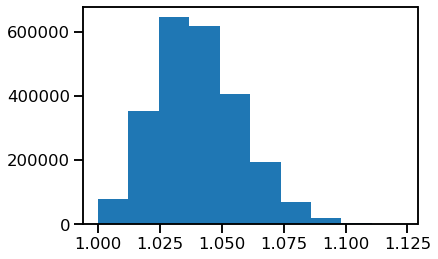

In [42]:
plt.hist(ran['weight'][ran['lambda_in']>25.])

## Build Footprint

In [45]:
def radec_to_pix(ra,dec,nside=4):
    thetas,phis = np.radians(90-dec),np.radians(ra)
    return hp.ang2pix(nside, thetas, phis,nest=False)

In [46]:
Nside = 64
npix = hp.nside2npix(Nside)
hpx_rm = np.array(radec_to_pix(rm['ra'],rm['dec'],nside=Nside))
hpx_ran = np.array(radec_to_pix(ran['ra'],ran['dec'],nside=Nside))

hpxmap = np.zeros(npix, dtype=np.int)
w, values = np.unique(hpx_ran,return_counts=True)
hpxmap[w] = values

/tmp/ipykernel_13202/2758194061.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hpxmap = np.zeros(npix, dtype=np.int)


Text(0.5, 1.0, 'DES Y3: Random RedMaPPer Footprint')

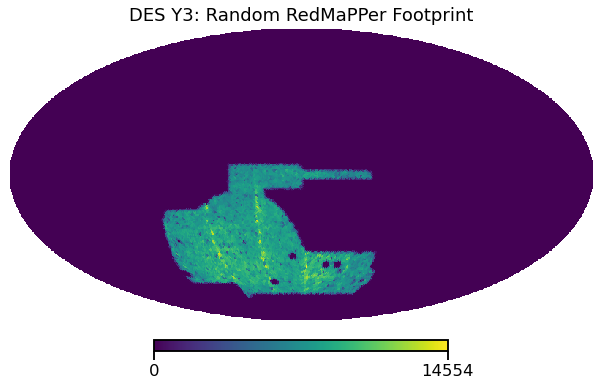

In [47]:
hp.mollview(hpxmap)
plt.title('DES Y3: Random RedMaPPer Footprint')

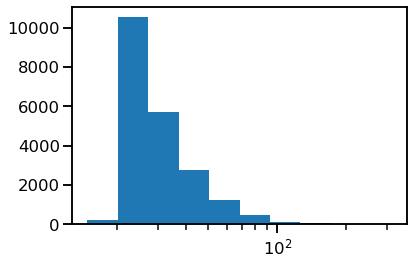

In [56]:
plt.hist(rm['lambda_chisq'][rm['lambda_chisq']>20.],bins=np.logspace(1.17, 2.5, 11))
plt.xscale('log')

In [66]:
np.count_nonzero(rm['lambda_chisq']>20.)/(5000*60**2)

0.001171888888888889

## JackKnife

In [17]:
from jackEstimator import JackKnifer

In [32]:
nside_jk = 8 #this is the low-resolution nside to define the JK masks. QUanto menor o valor, maior sera sua mascara/menor o numero 
#total de patches a serem removidos
jk =  JackKnifer(nside_jk, hpxmap, frac_thr= 0.8)
npatches = jk.npatches
print('total Jk patches are', npatches)


total Jk patches are 83


# Count-Count Correlation

In [33]:
import treecorr
config ={
         'dec_col': 'dec',
         'dec_units': 'degrees',
         'ra_col': 'ra',
         'ra_units': 'degrees',
         'sep_units': 'arcmin',
         'max_sep': 100,
         'min_sep': 1,
         'nbins': 20,
         'verbose': 0
        }

def get_angular_correlation(data, randoms, config=config):
    # load data and random catalogs
    cat = treecorr.Catalog(ra=data['ra'], dec=data['dec'], ra_units='degrees', dec_units='degrees')
    rcat = treecorr.Catalog(ra=randoms['ra'], dec=randoms['dec'], ra_units='degrees', dec_units='degrees')
    
    # process data catalog
    dd = treecorr.NNCorrelation(config)
    dd.process(cat)
    
    # process random catalog (it takes longer)
    rr = treecorr.NNCorrelation(config)
    rr.process(rcat)
    
    # return Landy & Szalay estimator
    xi, varxi = dd.calculateXi(rr)
    r = np.exp(dd.meanlogr)
    sig = np.sqrt(varxi)
    
    # clean memory
    rcat = cat = 0
    rr = dd = 0
    return r, xi

In [34]:
for kk in range(npatches):
    print('Patch %i'%kk)
    fname = './data/xi_jk_patches_{:05d}'.format(kk)
    
    # find indices
    idx = jk.get_cat_indices(hpx_rm, kk)
    idx1= jk.get_cat_indices(hpx_ran, kk)
    
    # run correlation functions
    _r, _xi = get_angular_correlation(rm[idx], ran[idx1])
    
    # append results
    np.save(fname, _xi)
    print('Saved results: %s'%fname)

Patch 0
Saved results: ./data/xi_jk_patches_00000
Patch 1
Saved results: ./data/xi_jk_patches_00001
Patch 2
Saved results: ./data/xi_jk_patches_00002
Patch 3
Saved results: ./data/xi_jk_patches_00003
Patch 4
Saved results: ./data/xi_jk_patches_00004
Patch 5
Saved results: ./data/xi_jk_patches_00005
Patch 6
Saved results: ./data/xi_jk_patches_00006
Patch 7
Saved results: ./data/xi_jk_patches_00007
Patch 8
Saved results: ./data/xi_jk_patches_00008
Patch 9
Saved results: ./data/xi_jk_patches_00009
Patch 10
Saved results: ./data/xi_jk_patches_00010
Patch 11
Saved results: ./data/xi_jk_patches_00011
Patch 12
Saved results: ./data/xi_jk_patches_00012
Patch 13
Saved results: ./data/xi_jk_patches_00013
Patch 14
Saved results: ./data/xi_jk_patches_00014
Patch 15
Saved results: ./data/xi_jk_patches_00015
Patch 16
Saved results: ./data/xi_jk_patches_00016
Patch 17
Saved results: ./data/xi_jk_patches_00017
Patch 18
Saved results: ./data/xi_jk_patches_00018
Patch 19
Saved results: ./data/xi_jk_patc

In [35]:
fname_base = './data/xi_jk_patches_{:05d}.npy'
vec = [np.load(fname_base.format(kk)) for kk in range(npatches)]

In [36]:
vec = np.vstack(vec)

### Compute Covariance

In [37]:
def get_jk_cov(jk_stats,npatches):
    """
    Get JackKnife covariance and error bar. 
 
    Args:
        jk_stats (array): array with the statistics computed for each JK patch
        npatches (float): number of JK patches 
    """
    mgg  = np.mean(jk_stats, axis =0)
    cov_jk  = np.sum((jk_stats - mgg[None, :])[:, :, None] *
                 (jk_stats - mgg[None, :])[:, None, :], axis=0)
    cov_jk *= ((npatches - 1.)/npatches)  
    sig_jk  = np.sqrt(np.diag(cov_jk))
    return cov_jk, sig_jk

In [38]:
cov, sig = get_jk_cov(vec, jk.npatches)

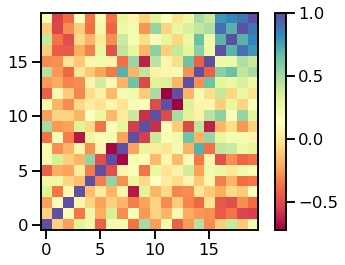

In [45]:
plt.imshow(np.corrcoef(cov),origin='lower',cmap='Spectral')
plt.colorbar()

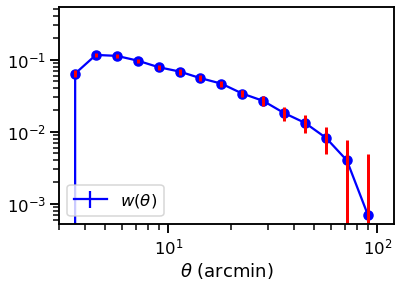

In [40]:
xi = np.mean(vec,axis=0)
r = _r

plt.scatter(r, xi, color='blue')
plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='r', lw=3, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='r', lw=3, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (arcmin)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([3,120])
plt.show()

### Run to clusters

In [ ]:
from __future__ import print_function
import pprint

config = treecorr.read_config('config_file.yaml')
print(pprint.pformat(config))

In [ ]:
dd = treecorr.NNCorrelation(config)
# dd.process()

In [ ]:
cat = treecorr.Catalog(ra=rm['ra'], dec=rm['dec'], ra_units='degrees', dec_units='degrees')
rcat = treecorr.Catalog(ra=ran['ra'], dec=ran['dec'], ra_units='degrees', dec_units='degrees')

In [ ]:
dd = treecorr.NNCorrelation(config)
dd.process(cat)

In [ ]:
rr = treecorr.NNCorrelation(config)
rr.process(rcat)

In [ ]:
# plt.hist(rm['z_lambda'])

## Plot Results

In [ ]:
xi, varxi = dd.calculateXi(rr)
r = np.exp(dd.meanlogr)
sig = np.sqrt(varxi)

plt.scatter(r, xi, color='blue')
plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='r', lw=3, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='r', lw=3, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (arcmin)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([3,320])
plt.show()

We might want to from 6 arcmin up to 360 arcmin

In [ ]:
# plt.hist(np.abs(sig/xi),bins=np.linspace(0.,0.5,21))

In [ ]:
from astropy.io.fits import getdata

In [ ]:
# hpmap = hp.read_map('y3a2_footprint_griz_1exp_v2.0.fits.gz')
mask = hp.ud_grade(hpmap, nside_out=512)#.astype(int)

In [ ]:
mask[mask==hp.UNSEEN] = 0

In [ ]:
hp.mollview(mask)